In [24]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fpath = '../data/scVelo/AL1.h5ad'
AL1 = anndata.read_h5ad(fpath) # 

In [43]:
sample = 'AL1' # ssgsea using all tcga samples
method = 'ssgsea' # gsva
keywords = ['BIOCARTA_NFKB_PATHWAY']

print(keywords)

for n, keyword in enumerate(keywords):

    fpath = '../data/GSVA/{}_{}.{}.csv'.format(sample, keyword, method)
    tmp = pd.read_csv(fpath, index_col=0)
    if keyword == 'Regulon':
        tmp.index = ['%s_Regulon'%x for x in tmp.index]

    gsva = tmp if n==0 else pd.concat((gsva, tmp))
print(gsva.shape)

gsva.columns = [x.replace('.',':') for x in gsva.columns]

print(gsva.index)
gsva.tail(4)

['BIOCARTA_NFKB_PATHWAY']


FileNotFoundError: [Errno 2] File ../data/GSVA/AL1_BIOCARTA_NFKB_PATHWAY.ssgsea.csv does not exist: '../data/GSVA/AL1_BIOCARTA_NFKB_PATHWAY.ssgsea.csv'

In [9]:
df_p = gsva.T.join(AL1.obs[['CellType']])


In [17]:
# test
from scipy.stats import ks_2samp

sel_terms = ['HALLMARK_P53_PATHWAY', 'HALLMARK_APOPTOSIS', 
             'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_TGF_BETA_SIGNALING',
             'HALLMARK_E2F_TARGETS', 'HALLMARK_G2M_CHECKPOINT']
glist = sel_terms 
ks_res = np.empty((len(glist), 3))

for n, g in enumerate(glist):
    x1 = df_p[g][df_p['CellType']=='T47D KO'].values
    x2 = df_p[g][df_p['CellType']=='T47D WT'].values
    x1 = x1[abs(x1) < 1e308] 
    x2 = x2[abs(x2) < 1e308] 

    stat, p = ks_2samp(x1, x2)
    sg_stat = stat if np.median(x1) > np.median(x2) else (-1)*stat
    ks_res[n,:] = [stat, sg_stat, p]
    
ks_df = pd.DataFrame(ks_res, columns=['ks','sg_ks','p'], index=glist).sort_values(by='sg_ks', ascending=False)

from statsmodels.stats.multitest import multipletests
ks_df['FDR'] = multipletests(ks_df['p'])[1] 
ks_df[ks_df['FDR']<0.05] 

,ks,sg_ks,p,FDR
HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.245876,0.245876,8.970602e-14,7.176482e-13
HALLMARK_P53_PATHWAY,0.233388,0.233388,1.925238e-12,1.347666e-11
HALLMARK_TGF_BETA_SIGNALING,0.125557,0.125557,6.648068e-04,2.656577e-03
HALLMARK_APOPTOSIS,0.098816,0.098816,1.380343e-02,4.084133e-02
HALLMARK_E2F_TARGETS,0.181779,-0.181779,1.050203e-07,5.251012e-07
HALLMARK_G2M_CHECKPOINT,0.191818,-0.191818,1.563397e-08,9.380383e-08


In [21]:
mpl.rc('figure', dpi=300)
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', 
font_scale=1.2, color_codes=True)

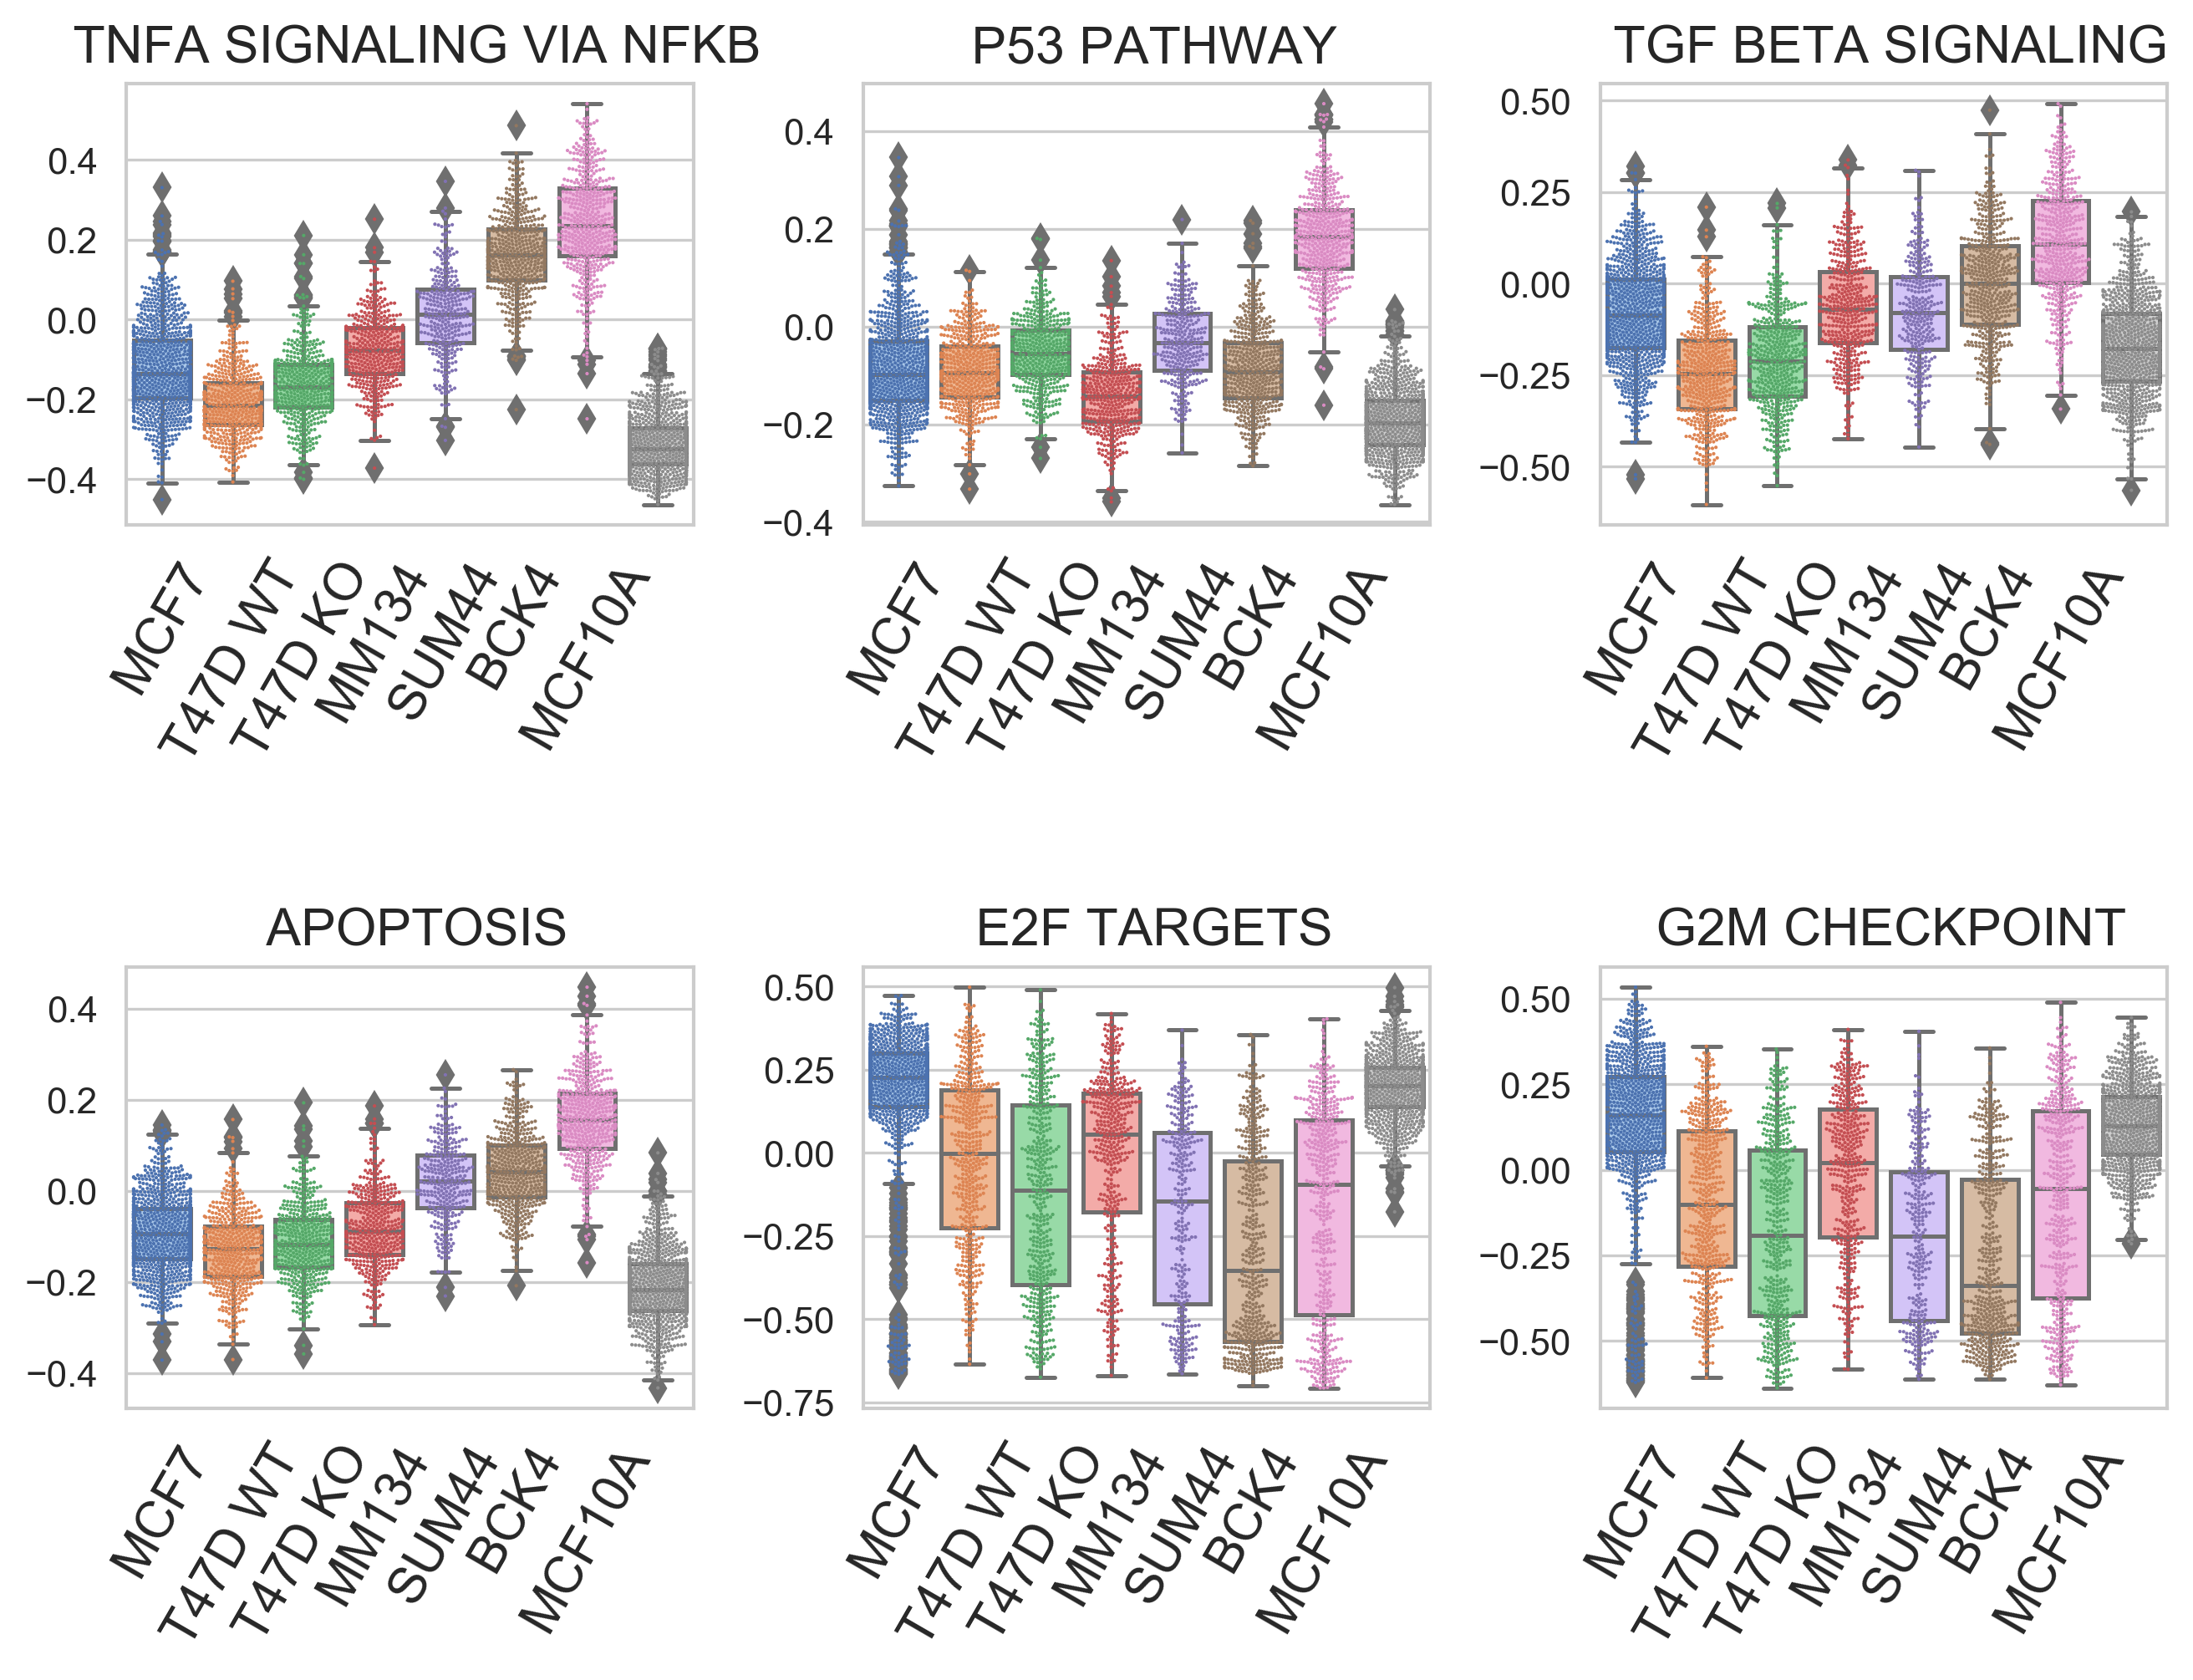

In [25]:
from math import ceil
sel_terms = [x for x in ks_df[ks_df['FDR']<0.05].index if x != 'IRF1_Regulon']
CellTypes = ['MCF7','T47D WT','T47D KO',  'MM134','SUM44','BCK4',  'MCF10A'] 

nplots = len(sel_terms)
ncols = 3 

nrows = ceil(nplots/ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3.5, nrows*3.5), dpi=300)
plt.subplots_adjust(wspace=0.3, hspace=1) # 
axes_list = axes.flatten()


for n in range(len(axes_list)):

    ax = axes_list[n]
    try:
        x = sel_terms[n] 
        sns.boxplot(x='CellType', y=x, data=df_p, ax=ax, palette='pastel') 
        sns.swarmplot(x='CellType', y=x, data=df_p, s=1, ax=ax, palette='deep') 
        
        ax.set_xlabel('')
        ax.set_xticklabels(CellTypes,fontsize=15,rotation=60)

        ax.set_ylabel('')
        ax.set_title(x.replace('_',' ').replace('CellCycle','CELL CYCLE').strip('HALLMARK'),fontsize=15)
    except:
        ax.axis('off')
        
# plt.savefig('../Figure/Fig5/AL1_CoexpressedSignatures.png', dpi=300, bbox_inches='tight')

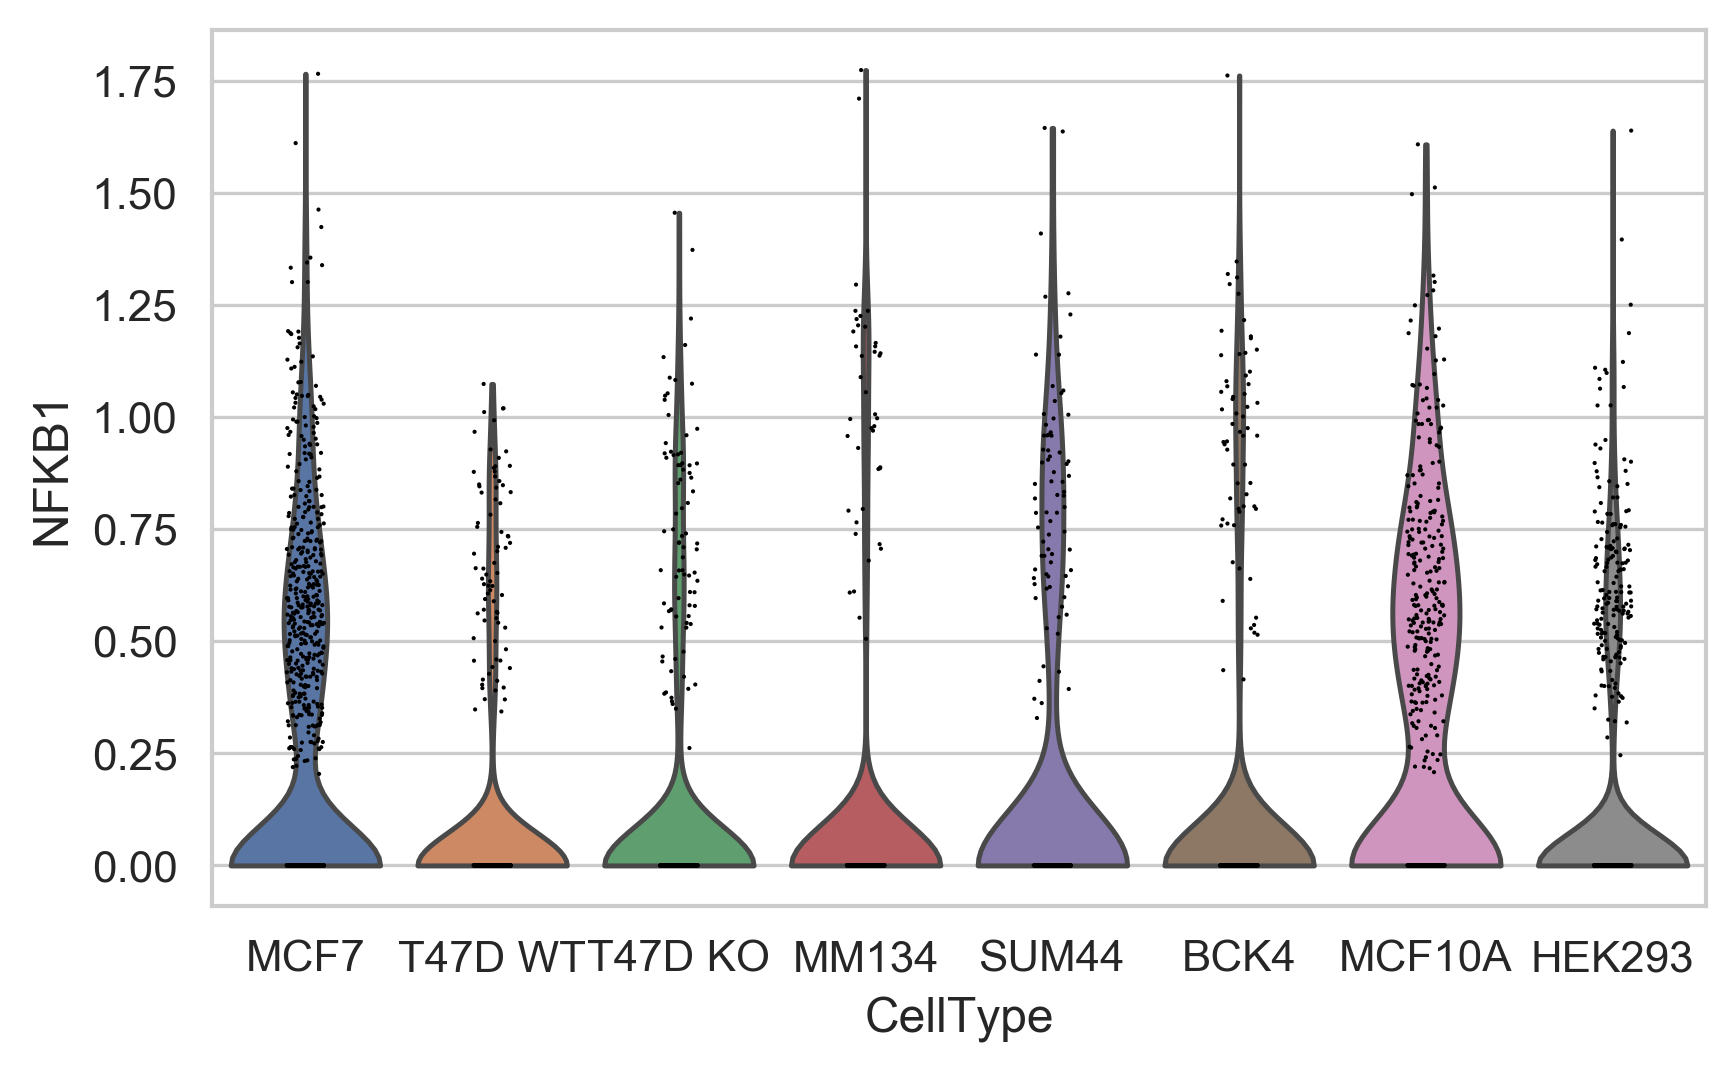

In [36]:
sc.pl.violin(AL1, keys=['NFKB1'],groupby='CellType')

# GSVA

## AL1

In [41]:
wkdir='/Users/chelseachen/Box/WCRC/Lee-Oesterreich-lab-personnel/Current/Chelsea/projects/CellLines'
keyword = 'BIOCARTA_NFKB_PATHWAY'
sample = 'AL1'

for method in ['gsva', 'ssgsesa']:

    gmt_path = '{}/data/gmt/{}.gmt'.format(wkdir, keyword)
    expr_path = '{}/data/Counts/adata_ref_norm.logNormCts.csv'.format(wkdir, sample) # gene x cell
    gsvaPrefix = '{}/data/GSVA/{}_{}'.format(wkdir,sample, keyword)

#     if not isfile('{}.{}.csv'.format(gsvaPrefix, method)):
    cmd = 'Rscript %s/codes/GSVA.R %s %s %s %s &\n'%(wkdir, expr_path, gmt_path, gsvaPrefix, method)
    print(cmd)

Rscript /Users/chelseachen/Box/WCRC/Lee-Oesterreich-lab-personnel/Current/Chelsea/projects/CellLines/codes/GSVA.R /Users/chelseachen/Box/WCRC/Lee-Oesterreich-lab-personnel/Current/Chelsea/projects/CellLines/data/Counts/adata_ref_norm.logNormCts.csv /Users/chelseachen/Box/WCRC/Lee-Oesterreich-lab-personnel/Current/Chelsea/projects/CellLines/data/gmt/BIOCARTA_NFKB_PATHWAY.gmt /Users/chelseachen/Box/WCRC/Lee-Oesterreich-lab-personnel/Current/Chelsea/projects/CellLines/data/GSVA/AL1_BIOCARTA_NFKB_PATHWAY gsva &

Rscript /Users/chelseachen/Box/WCRC/Lee-Oesterreich-lab-personnel/Current/Chelsea/projects/CellLines/codes/GSVA.R /Users/chelseachen/Box/WCRC/Lee-Oesterreich-lab-personnel/Current/Chelsea/projects/CellLines/data/Counts/adata_ref_norm.logNormCts.csv /Users/chelseachen/Box/WCRC/Lee-Oesterreich-lab-personnel/Current/Chelsea/projects/CellLines/data/gmt/BIOCARTA_NFKB_PATHWAY.gmt /Users/chelseachen/Box/WCRC/Lee-Oesterreich-lab-personnel/Current/Chelsea/projects/CellLines/data/GSVA/AL1_BI

In [30]:
ref_norm = sc.read('../data/scVelo/AL1_ref_norm.h5ad')
'NFKB1' in ref_norm.var_names

True

## TCGA

In [ ]:
wkdir = '/bgfs/alee/chelsea/projects/10X/CellLine'
keyword = 'Regulon'
sample = 'tcga'

for method in ['gsva', 'ssgsesa']:

    gmt_path = '{}/data/GSVA/{}.gmt'.format(wkdir, keyword)
    expr_path = '{}/data/TCGA15/{}.logNormCts.csv'.format(wkdir, sample) # gene x cell
    gsvaPrefix = '{}/data/GSVA/{}_{}'.format(wkdir,sample, keyword)

#     if not isfile('{}.{}.csv'.format(gsvaPrefix, method)):
    cmd = 'srun -t1:00:00 --cpus-per-task 12 /ihome/crc/install/gcc-8.2.0/r/3.6.0/bin/Rscript %s/codes/GSVA.R %s %s %s %s &\n'%(wkdir, expr_path, gmt_path, gsvaPrefix, method)
    print(cmd)